In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

We import 20 stocks in energy industry

In [17]:
import yfinance as yf

# Stock in SP500 energy industry
sp500_energy_stocks = [
    'XOM',
    'CVX',
    'COP',
    'EOG',
    'SLB',
    'APA',
    'PSX',
    'MPC',
    'VLO',
    'OXY',
    'KMI',
    'WMB',
    'DVN',
    'HAL',
    'BKR',
    'OKE',
    'FANG',
    'CTRA',
    'EQT',
    'HES']

sector_dict = {
    'XOM': 'Energy',
    'CVX': 'Energy',
    'COP': 'Energy',
    'EOG': 'Energy',
    'SLB': 'Energy',
    'APA': 'Energy',
    'PSX': 'Energy',
    'MPC': 'Energy',
    'VLO': 'Energy',
    'OXY': 'Energy',
    'KMI': 'Energy',
    'WMB': 'Energy',
    'DVN': 'Energy',
    'HAL': 'Energy',
    'BKR': 'Energy',
    'OKE': 'Energy',
    'FANG': 'Energy',
    'CTRA': 'Energy',
    'EQT': 'Energy',
    'HES': 'Energy'
}

In [18]:
df = yf.download(sp500_energy_stocks, start="2021-12-01", end="2024-01-03", group_by='ticker')

df = df.stack(level=0, future_stack=True).reset_index()

df.rename(columns={'level_1': 'Ticker'}, inplace=True)

[*********************100%***********************]  20 of 20 completed


In [19]:
df['Sector'] = df['Ticker'].map(sector_dict)

In [20]:
print(df.head(10))

Price       Date Ticker       Open       High        Low      Close    Volume  \
0     2021-12-01    VLO  62.141761  63.916212  60.394338  60.628525   5872500   
1     2021-12-01    XOM  54.288367  55.295685  53.263216  53.298874  30630600   
2     2021-12-01    OXY  29.588278  29.858226  27.872177  27.910742  19000400   
3     2021-12-01    EOG  74.696811  75.122792  71.188744  71.288971   5594600   
4     2021-12-01    OKE  51.476010  51.718744  49.073797  49.090538   2856100   
5     2021-12-01    DVN  36.322427  36.322427  33.685456  33.759853  12620600   
6     2021-12-01    BKR  22.364698  22.724526  21.589684  21.608137   9814200   
7     2021-12-01   FANG  92.453727  92.757602  86.865822  86.941788   4079700   
8     2021-12-01    PSX  63.250013  63.630930  60.796192  60.831627   3976800   
9     2021-12-01    MPC  58.059955  59.275531  56.454653  56.519608   6552400   

Price  Sector  
0      Energy  
1      Energy  
2      Energy  
3      Energy  
4      Energy  
5      Energ

In [21]:
df.shape

(10480, 8)

## Same Preprocessing as Previous

In [22]:
df['Year'] = df['Date'].dt.year

In [23]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.copy()

In [24]:
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['Momentum'] = df['Close'].diff(5)
df['Volatility'] = df['Close'].rolling(10).std()
df['Price_Change'] = df['Close'].pct_change()
df['Volume_Change'] = df['Volume'].pct_change()
df['Rolling_Max_10'] = df['High'].rolling(10).max()
df['Rolling_Min_10'] = df['Low'].rolling(10).min()

In [25]:
def compute_rsi(series, window=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))
df['RSI_14'] = compute_rsi(df['Close'], window=14)

In [26]:
df['Bollinger_Upper'] = df['MA_20'] + 2 * df['Volatility']
df['Bollinger_Lower'] = df['MA_20'] - 2 * df['Volatility']

In [27]:
# Ensure 'Year' is an integer
df['Year'] = df['Year'].astype(int)

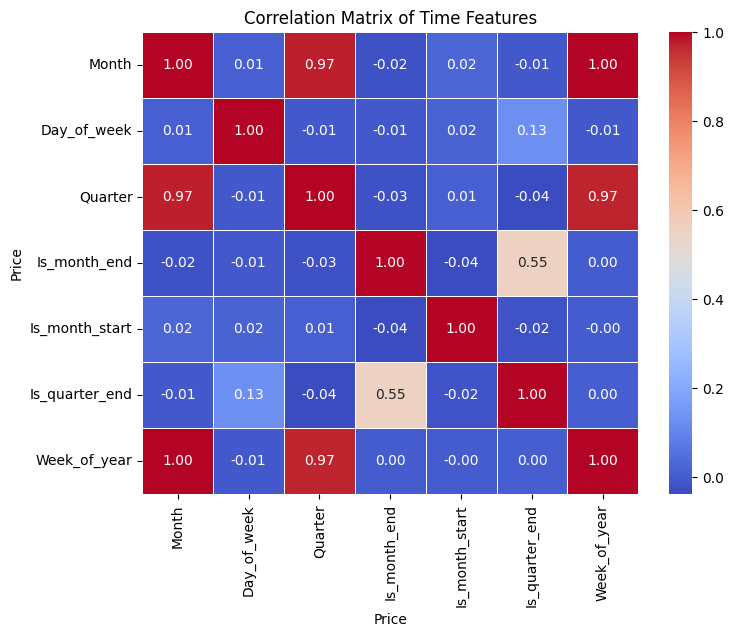


Features to be dropped due to high correlation: {'Week_of_year', 'Quarter'}


In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Add time series features
df['Month'] = df['Date'].dt.month
df['Day_of_week'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Convert boolean features to integer directly
df['Is_month_end'] = df['Date'].dt.is_month_end.astype(int)
df['Is_month_start'] = df['Date'].dt.is_month_start.astype(int)
df['Is_quarter_end'] = df['Date'].dt.is_quarter_end.astype(int)
df['Week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# List of time features
time_features = ['Month', 'Day_of_week', 'Quarter', 'Is_month_end',
                 'Is_month_start', 'Is_quarter_end', 'Week_of_year']

# Compute correlation matrix
correlation_matrix = df[time_features].corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Time Features")
plt.show()

# Identify highly correlated features (threshold > 0.9)
high_correlation = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[i]
            high_correlation.add(colname)

print("\nFeatures to be dropped due to high correlation:", high_correlation)

# Drop highly correlated features
df.drop(columns=high_correlation, axis=1, inplace=True)


## **Classification model**

### Additional Feature Engineering for the classification problem

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import pickle
import warnings
warnings.filterwarnings('ignore')

# ML model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Hypertuning
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint


# Create Target Variable
df['Target'] = (df.groupby('Ticker')['Close'].shift(-1) > df['Close']).astype(int)

# Additional Feature Engineering
def add_features(df):
    # Time lag
    for i in range(1, 6):
        df[f'Close_Lag_{i}'] = df.groupby('Ticker')['Close'].shift(i)
        df[f'Return_Lag_{i}'] = df.groupby('Ticker')['Price_Change'].shift(i)

    # Relative strength
    df['Date'] = pd.to_datetime(df['Date'])
    daily_industry = df.groupby('Date')[['Close', 'Volume']].mean()
    daily_industry.columns = ['Industry_Avg_Close', 'Industry_Avg_Volume']
    df = pd.merge(df, daily_industry, on='Date', how='left')
    df['Relative_Strength'] = df['Close'] / df['Industry_Avg_Close']
    df['Industry_Rank'] = df.groupby('Date')['Close'].rank(pct=True)

    # Trend direction
    df['Price_Up'] = (df['Close'] > df['Open']).astype(int)
    df['Price_Up_Lag1'] = df.groupby('Ticker')['Price_Up'].shift(1)
    df['Price_Up_Lag2'] = df.groupby('Ticker')['Price_Up'].shift(2)


    return df

# Apply the features
df = add_features(df)

features = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Month', 'Day_of_week', 'Is_month_end', 'Is_month_start', 'Is_quarter_end',
    'MA_5', 'MA_20', 'RSI_14', 'Momentum', 'Volatility',
    'Relative_Strength', 'Industry_Rank',
    'Close_Lag_1', 'Close_Lag_2', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3'
]


In [30]:
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,Sector,Year,MA_5,...,Return_Lag_4,Close_Lag_5,Return_Lag_5,Industry_Avg_Close,Industry_Avg_Volume,Relative_Strength,Industry_Rank,Price_Up,Price_Up_Lag1,Price_Up_Lag2
0,2021-12-01,VLO,62.141761,63.916212,60.394338,60.628525,5872500,Energy,2021,NaN,...,NaN,NaN,NaN,44.528658,10708605.0,1.361562,0.70,0,NaN,NaN
1,2021-12-01,XOM,54.288367,55.295685,53.263216,53.298874,30630600,Energy,2021,NaN,...,NaN,NaN,NaN,44.528658,10708605.0,1.196957,0.60,0,NaN,NaN
2,2021-12-01,OXY,29.588278,29.858226,27.872177,27.910742,19000400,Energy,2021,NaN,...,NaN,NaN,NaN,44.528658,10708605.0,0.626804,0.45,0,NaN,NaN
3,2021-12-01,EOG,74.696811,75.122792,71.188744,71.288971,5594600,Energy,2021,NaN,...,NaN,NaN,NaN,44.528658,10708605.0,1.600968,0.90,0,NaN,NaN
4,2021-12-01,OKE,51.476010,51.718744,49.073797,49.090538,2856100,Energy,2021,52.44353,...,NaN,NaN,NaN,44.528658,10708605.0,1.102448,0.55,0,NaN,NaN


### Deal with the null

In [31]:
df.isnull().sum()

,0
Date,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Volume,0
Sector,0
Year,0
MA_5,4


In [32]:
def handle_missing_values(df):
    df_copy = df.copy()

    # Technical indicators
    # Moving averages and Bollinger Bands
    for col in ['MA_5', 'MA_20', 'Bollinger_Upper', 'Bollinger_Lower']:
        df_copy[col] = df_copy.groupby('Ticker')[col].transform(
            lambda x: x.fillna(method='ffill').fillna(x.mean() if not x.dropna().empty else 0)
        )

    # Volatility metrics
    for col in ['Volatility', 'Rolling_Max_10', 'Rolling_Min_10']:
        df_copy[col] = df_copy.groupby('Ticker')[col].transform(
            lambda x: x.fillna(method='ffill').fillna(x.mean() if not x.dropna().empty else 0)
        )

    # RSI (fill with neutral value 50)
    df_copy['RSI_14'] = df_copy.groupby('Ticker')['RSI_14'].transform(
        lambda x: x.fillna(method='ffill').fillna(50)
    )

    # Price and volume changes
    for col in ['Price_Change', 'Volume_Change', 'Momentum']:
        df_copy[col] = df_copy[col].fillna(0)  # Default: no change

    # Lagged features
    # Price lags
    for i in range(1, 6):
        lag_col = f'Close_Lag_{i}'
        if lag_col in df_copy.columns:
            df_copy[lag_col] = df_copy.groupby('Ticker')[lag_col].transform(
                lambda x: x.fillna(df_copy.loc[x.index, 'Close'].iloc[0] if not x.empty else 0)
            )

    # Return lags
    for i in range(1, 6):
        ret_lag_col = f'Return_Lag_{i}'
        if ret_lag_col in df_copy.columns:
            df_copy[ret_lag_col] = df_copy[ret_lag_col].fillna(0)  # Assume no change

    # Price up flag lags
    for i in range(1, 3):
        up_lag_col = f'Price_Up_Lag{i}'
        if up_lag_col in df_copy.columns:
            mean_val = df_copy[up_lag_col].mean()
            df_copy[up_lag_col] = df_copy[up_lag_col].fillna(mean_val)

    return df_copy

df = handle_missing_values(df)


df.isnull().sum()

,0
Date,0
Ticker,0
Open,0
High,0
Low,0
Close,0
Volume,0
Sector,0
Year,0
MA_5,0


## Data Preparation for three models

In [45]:
# Prepare data
# Data Split
split_date = df['Date'].max() - pd.Timedelta(days=60)
train_data = df[df['Date'] < split_date].copy()
test_data = df[(df['Date'] >= split_date) & (df['Date'] <= '2024-01-03')].copy()


# For RF and XG
X_train = train_data[features]
y_train = train_data['Target']
X_test = test_data[features]
y_test = test_data['Target']


from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)




# For LSTM
def prepare_lstm_data(df, feature_list, sequence_length=10):
    data = []
    labels = []

    df = df.sort_values(['Ticker', 'Date'])

    for ticker in df['Ticker'].unique():
        ticker_data = df[df['Ticker'] == ticker]
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_features = scaler.fit_transform(ticker_data[feature_list])

        for i in range(len(ticker_data) - sequence_length):
            data.append(scaled_features[i:i+sequence_length])
            labels.append(ticker_data['Target'].iloc[i+sequence_length])

    return np.array(data), np.array(labels)

# Less feature for LSTM
lstm_features = [
    'Open', 'High', 'Close', 'Volume', 'RSI_14', 'MA_5','MA_20', 'Momentum','Volatility',
    'Relative_Strength', 'Industry_Rank', 'Volatility', 'Price_Change', 'Price_Up', 'Industry_Avg_Close','Month', 'Day_of_week', 'Is_month_end', 'Bollinger_Upper','Bollinger_Lower'
]


sequence_length = 30   # use 30 days to predict


train_dates = sorted(train_data['Date'].unique())
val_split_idx = int(len(train_dates) * 0.8)
val_split_date = train_dates[val_split_idx]

print(f"Train: {train_dates[0]} to {val_split_date}")
print(f"Val: {val_split_date} to {train_dates[-1]}")

train_data_final = train_data[train_data['Date'] < val_split_date].copy()
val_data = train_data[train_data['Date'] >= val_split_date].copy()

lstm_train_X, lstm_train_y = prepare_lstm_data(train_data, lstm_features, sequence_length)
lstm_val_X, lstm_val_y = prepare_lstm_data(train_data, lstm_features, sequence_length)
lstm_test_X, lstm_test_y = prepare_lstm_data(test_data, lstm_features, sequence_length)

# Data balance
neg_class_count = np.sum(lstm_train_y == 0)
pos_class_count = np.sum(lstm_train_y == 1)
weight_ratio = neg_class_count / pos_class_count

class_weights = {
    0: 1.0,
    1: weight_ratio
}

if pos_class_count > neg_class_count:
  class_weights = {
      0: pos_class_count / neg_class_count,
      1: 1.0
  }

Train: 2021-12-01 00:00:00 to 2023-06-16 00:00:00
Val: 2023-06-16 00:00:00 to 2023-11-02 00:00:00


### XGboosting

In [38]:
# Hypertuning
print("Start Hypertuning")

# cv for time series
tscv = TimeSeriesSplit(n_splits=5)

# XGBoost parameters
xgb_param_dist = {
    'n_estimators': [50,100,200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5]
}


# XGboost
xgb_search = RandomizedSearchCV(
    xgb.XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False),
    param_distributions=xgb_param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)
print("XGBoost best parameters:", xgb_search.best_params_)
print("XGBoost best accuracy:", xgb_search.best_score_)


Start Hypertuning
XGBoost best parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.01}
XGBoost best accuracy: 0.5021126760563381


In [49]:
### Random Forest

In [39]:
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'max_features': ['sqrt', 'log2', None]
}

rf_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=tscv,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("RandomForest best parameters:", rf_search.best_params_)
print("RandomForest best accuracy:", rf_search.best_score_)

RandomForest best parameters: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': 3}
RandomForest best accuracy: 0.5003521126760564


### LSTM

In [46]:
# LSTM

def create_lstm_model(units=32, dropout=0.2, learning_rate = 0.001):
    model = Sequential([
        LSTM(units=units, return_sequences=False,
             input_shape=(sequence_length, len(lstm_features))),
        BatchNormalization(),
        Dropout(dropout),
        Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(dropout),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# LSTM parameters
lstm_configs = [
    {'units': 32, 'dropout': 0.1, 'learning_rate': 0.01},
    {'units': 64, 'dropout': 0.2, 'learning_rate': 0.001},
    {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0005}
]

lstm_scores = []
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


best_val_accuracy = 0
best_lstm_config = None
best_lstm_model = None

for i, config in enumerate(lstm_configs):
    print(f"Hypertune {i+1}/{len(lstm_configs)}")
    model = create_lstm_model(**config)
    history = model.fit(
        lstm_train_X, lstm_train_y,
        epochs=50,
        batch_size=32,
        validation_data=(lstm_val_X, lstm_val_y),
        callbacks=[early_stopping],
        class_weight=class_weights,
        verbose=0
    )
    val_accuracy = max(history.history['val_accuracy'])
    lstm_scores.append((config, val_accuracy))

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_lstm_config = config
        # Save the best model
        best_lstm_model = model

print("LSTM best parameters:", best_lstm_config)
print("LSTM best accuracy:", best_val_accuracy)

Hypertune 1/3
Hypertune 2/3
Hypertune 3/3
LSTM best parameters: {'units': 128, 'dropout': 0.3, 'learning_rate': 0.0005}
LSTM best accuracy: 0.8036343455314636


In [41]:
best_xgb = xgb.XGBClassifier(**xgb_search.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)

best_rf = RandomForestClassifier(**rf_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, max_features='log2', n_estimators=200,
                       random_state=42)

## Model Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

XGBoost model result:
Accuracy: 0.6050
Precision: 0.5932
Recall: 0.3889
F1 score: 0.4698
AUC: 0.5036

classification report:
              precision    recall  f1-score   support

           0       0.61      0.78      0.69       110
           1       0.59      0.39      0.47        90

    accuracy                           0.60       200
   macro avg       0.60      0.59      0.58       200
weighted avg       0.60      0.60      0.59       200


Random Forest model result:
Accuracy: 0.5900
Precision: 0.5833
Recall: 0.3111
F1 score: 0.4058
AUC: 0.5438

classification report:
              precision    recall  f1-score   support

           0       0.59      0.82      0.69       110
           1       0.58      0.31      0.41        90

    accuracy                           0.59       200
   macro avg       0.59      0.56      0.55       200
weighted avg       0.59      0.59      0.56       200


LSTM model 

<Figure size 1200x800 with 0 Axes>

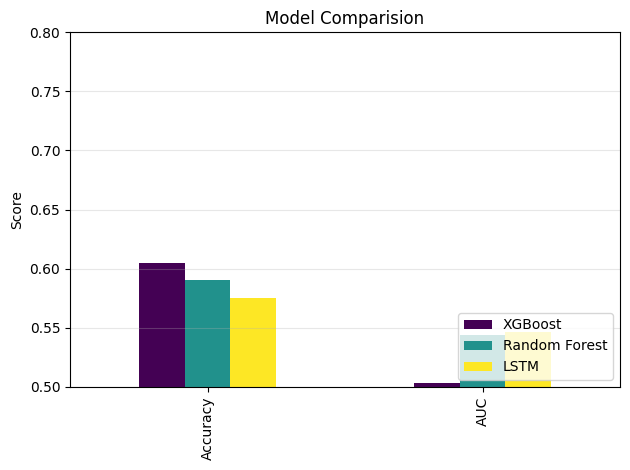


Model Comparision
            XGBoost  Random Forest      LSTM
Accuracy   0.605000       0.590000  0.575000
Precision  0.593220       0.583333  0.524272
Recall     0.388889       0.311111  0.600000
F1 score   0.469799       0.405797  0.559585
AUC        0.503586       0.543838  0.545960


In [47]:
# Evaluate the result
def get_predictions(model, X, is_lstm=False):
    if is_lstm:
        return (model.predict(X) > 0.5).astype(int).flatten()
    else:
        return model.predict(X)

def get_probabilities(model, X, is_lstm=False):
    if is_lstm:
        return model.predict(X).flatten()
    else:
        return model.predict_proba(X)[:, 1]

# Get prediction
xgb_preds = get_predictions(best_xgb, X_test)
rf_preds = get_predictions(best_rf, X_test)
lstm_preds = get_predictions(best_lstm_model, lstm_test_X, is_lstm=True)

xgb_probs = get_probabilities(best_xgb, X_test)
rf_probs = get_probabilities(best_rf, X_test)
lstm_probs = get_probabilities(best_lstm_model, lstm_test_X, is_lstm=True)



test_data['sequence_idx'] = -1

for ticker in test_data['Ticker'].unique():
    ticker_data = test_data[test_data['Ticker'] == ticker].sort_values('Date')
    if len(ticker_data) > sequence_length:
        for i in range(len(ticker_data) - sequence_length):
            test_data.loc[ticker_data.index[i+sequence_length], 'sequence_idx'] = i

# Keep LSTM prediction
common_samples = test_data[test_data['sequence_idx'] >= 0]
lstm_sample_count = lstm_test_X.shape[0]

if len(common_samples) > lstm_sample_count:
    common_samples = common_samples.iloc[:lstm_sample_count]
elif len(common_samples) < lstm_sample_count:
    lstm_preds = lstm_preds[:len(common_samples)]
    lstm_probs = lstm_probs[:len(common_samples)]

common_X = common_samples[features]
common_y = common_samples['Target']

xgb_common_preds = get_predictions(best_xgb, common_X)
rf_common_preds = get_predictions(best_rf, common_X)
xgb_common_probs = get_probabilities(best_xgb, common_X)
rf_common_probs = get_probabilities(best_rf, common_X)

# Evaluate the results
def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    print(f"\n{model_name} model result:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    print("\nclassification report:")
    print(classification_report(y_true, y_pred))

    # confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Fall', 'Rise'],
                yticklabels=['Fall', 'Rise'])
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title(f'{model_name} confusion matrix')
    plt.tight_layout()
    plt.close()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Evaluate all models
xgb_metrics = evaluate_model(common_y, xgb_common_preds, xgb_common_probs, "XGBoost")
rf_metrics = evaluate_model(common_y, rf_common_preds, rf_common_probs, "Random Forest")
lstm_metrics = evaluate_model(common_y, lstm_preds, lstm_probs, "LSTM")


# Compare models together
models_comparison = pd.DataFrame({
    'XGBoost': [xgb_metrics['accuracy'], xgb_metrics['precision'], xgb_metrics['recall'],
               xgb_metrics['f1'], xgb_metrics['auc']],
    'Random Forest': [rf_metrics['accuracy'], rf_metrics['precision'], rf_metrics['recall'],
                    rf_metrics['f1'], rf_metrics['auc']],
    'LSTM': [lstm_metrics['accuracy'], lstm_metrics['precision'], lstm_metrics['recall'],
            lstm_metrics['f1'], lstm_metrics['auc']]
})
models_comparison.index = ['Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC']

# Visualization
plt.figure(figsize=(12, 8))
models_comparison.loc[['Accuracy', 'AUC']].plot(kind='bar', colormap='viridis')
plt.title('Model Comparision')
plt.ylabel('Score')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0.5, 0.8)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print("\nModel Comparision")
print(models_comparison)

## Case Analysis

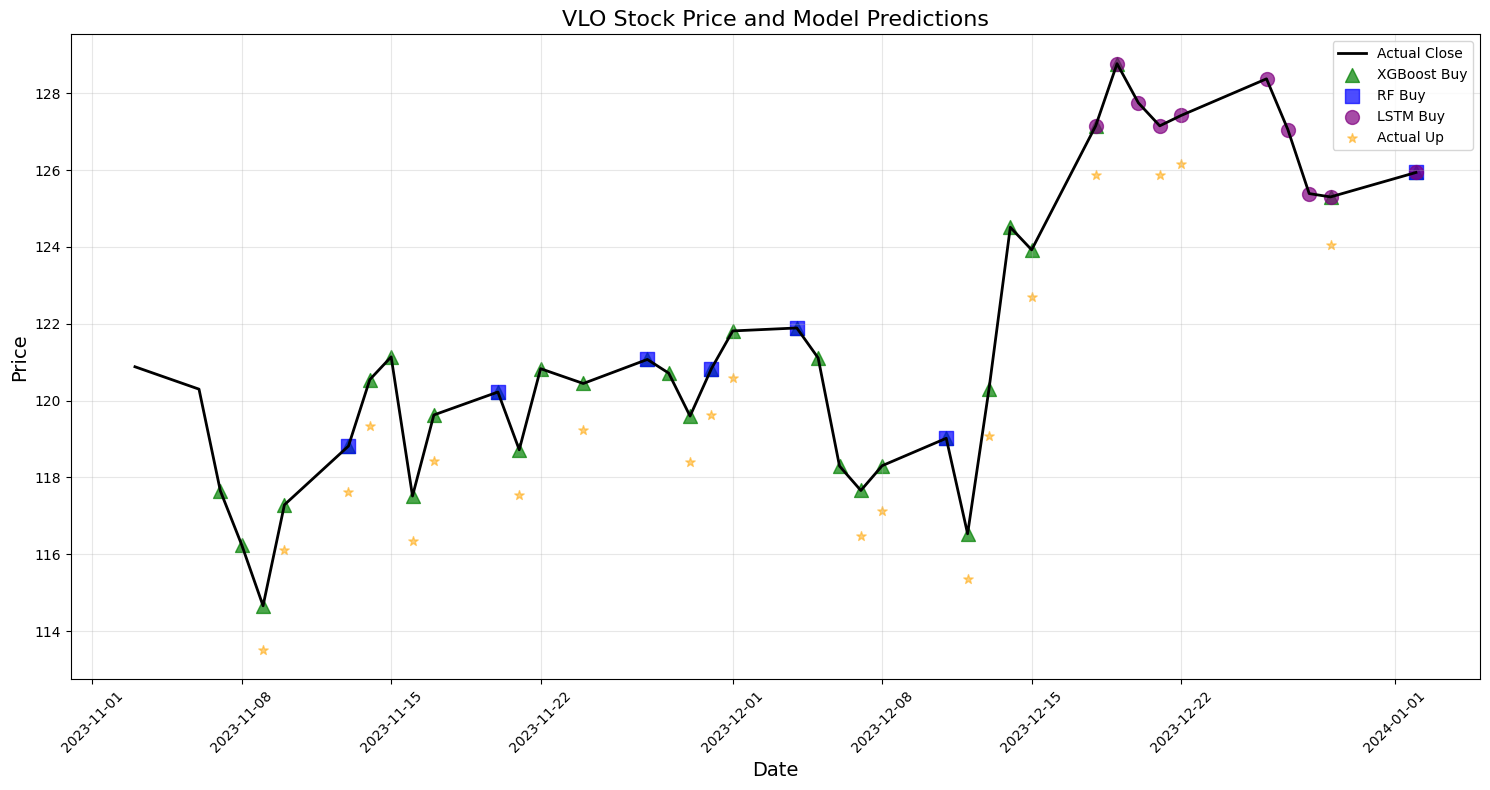


VLO Model Performance:
XGBoost Accuracy: 0.6000
RF Accuracy: 0.4250
LSTM Accuracy: 0.4000


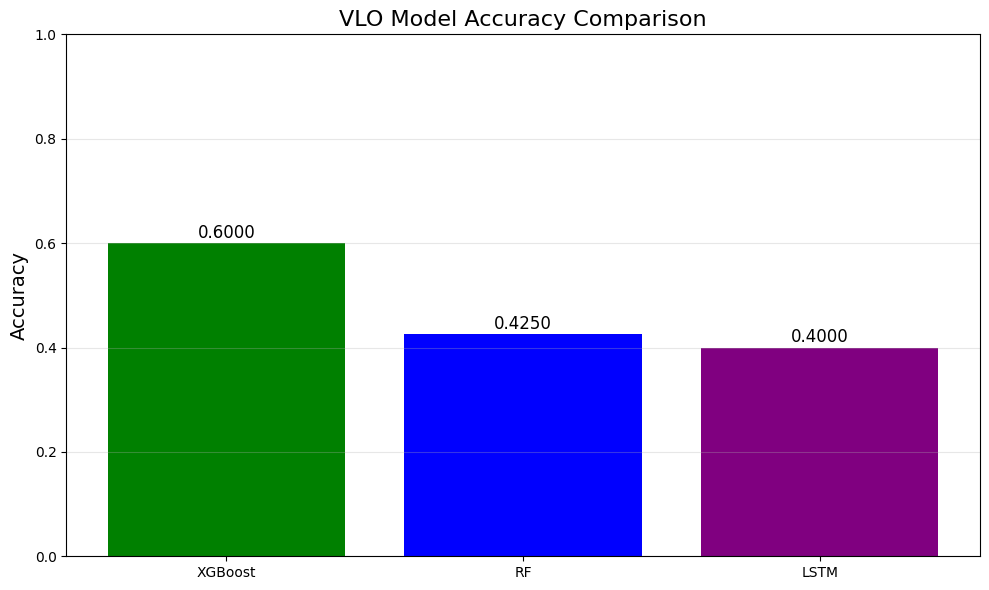

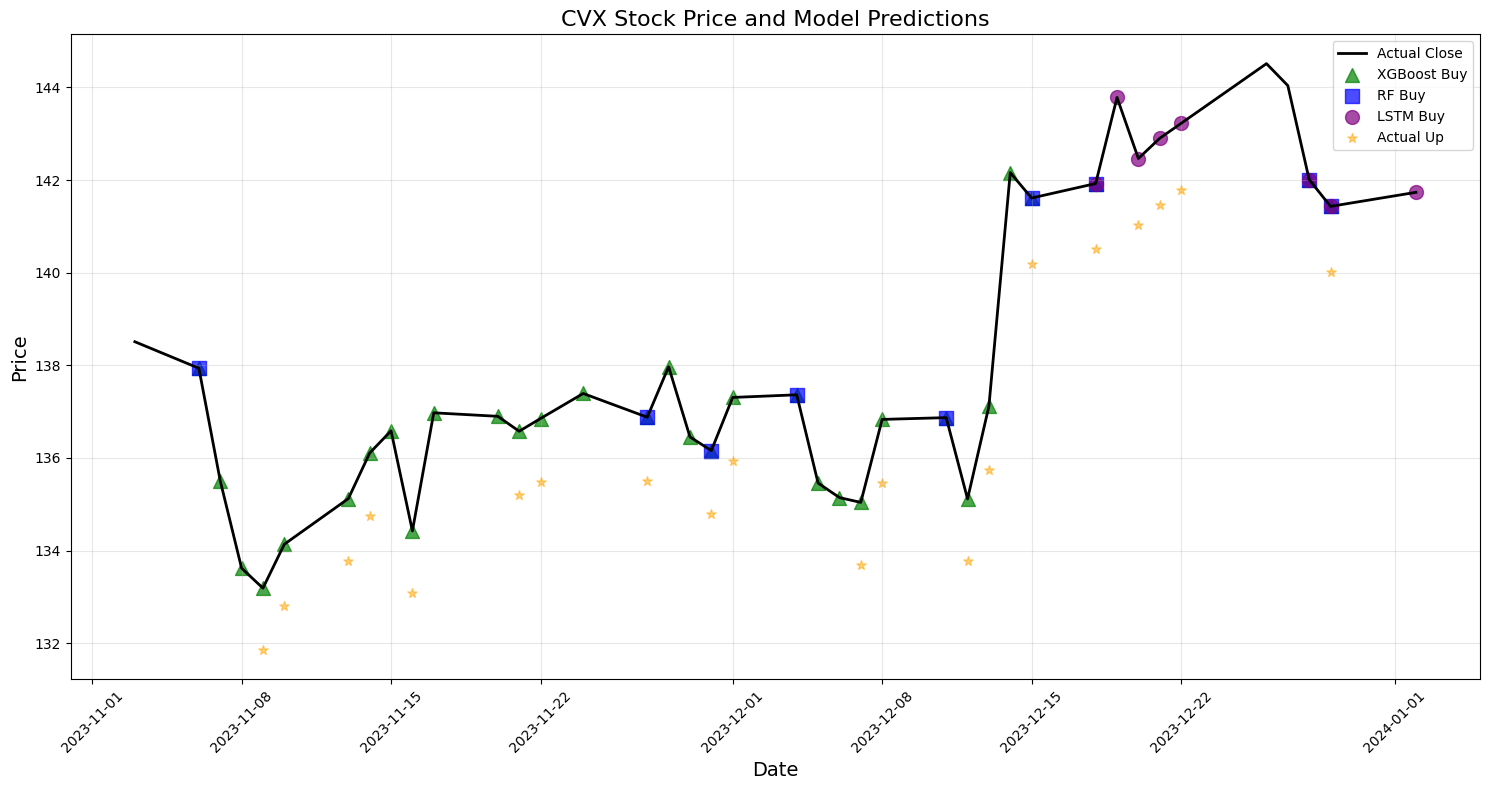


CVX Model Performance:
XGBoost Accuracy: 0.5500
RF Accuracy: 0.5250
LSTM Accuracy: 0.7000


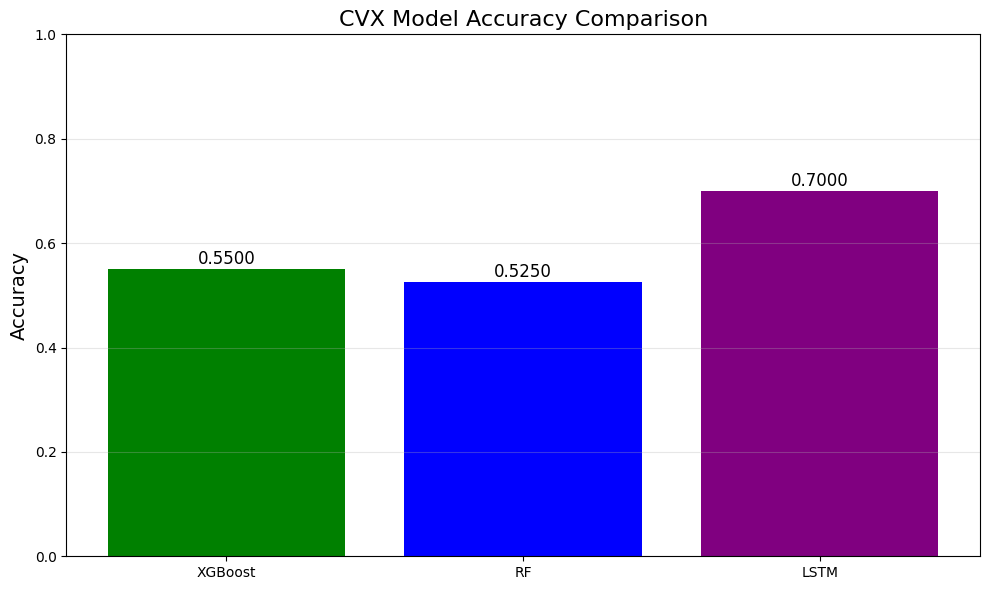

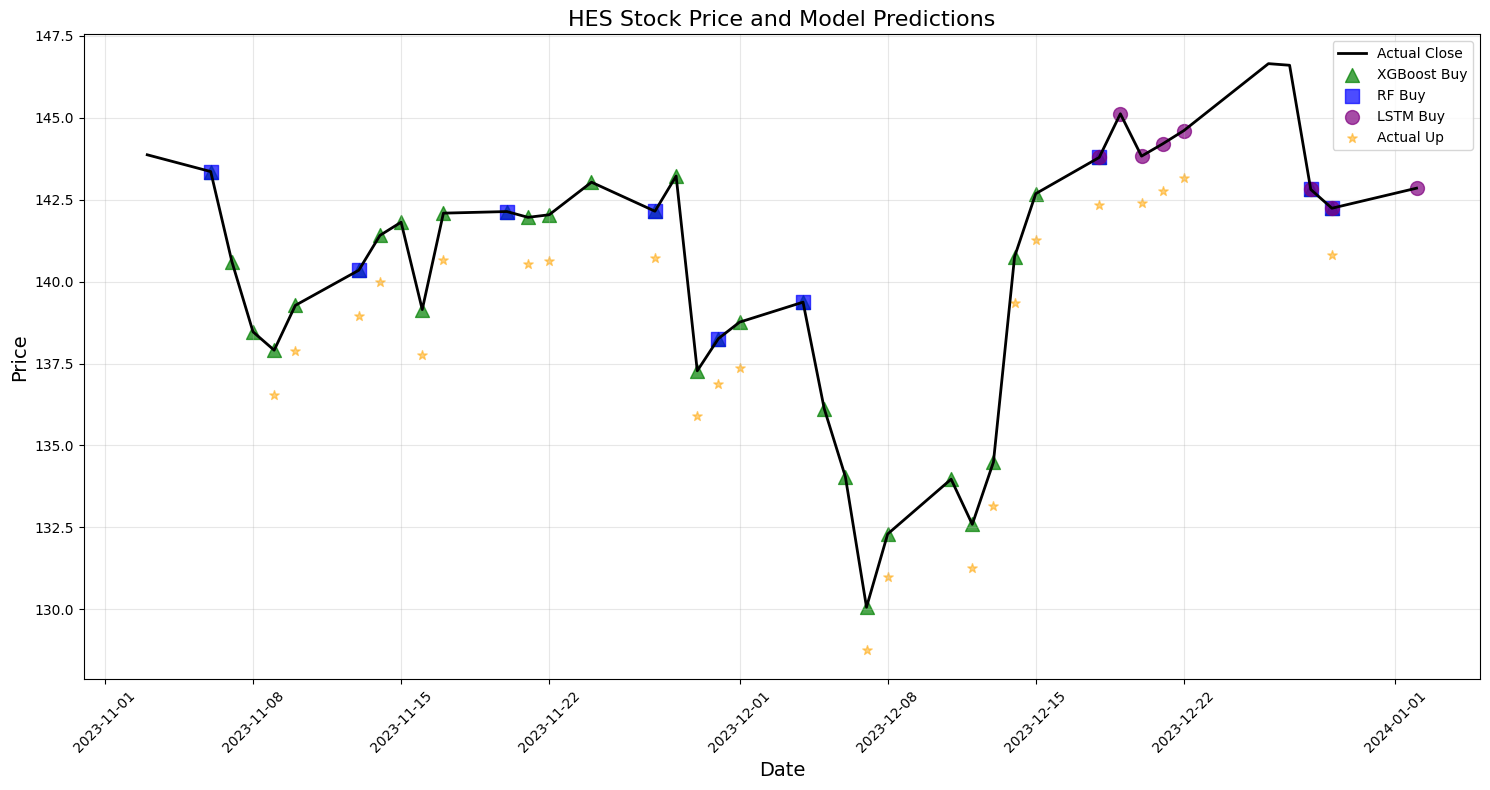


HES Model Performance:
XGBoost Accuracy: 0.6250
RF Accuracy: 0.4500
LSTM Accuracy: 0.7000


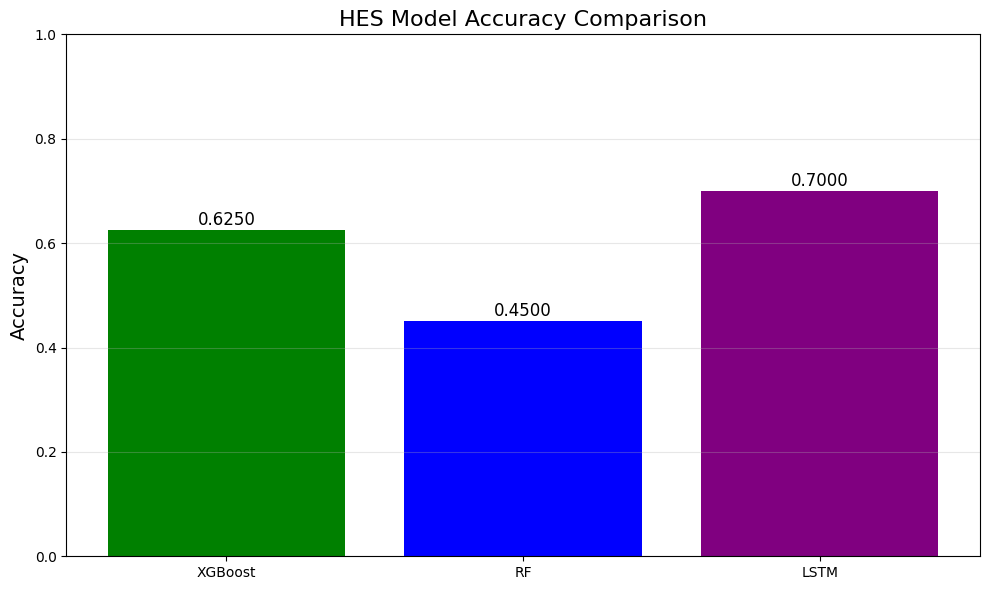

In [55]:
def plot_stocks_simple(test_data, ticker_list=['APA', 'HES']):
    """
    Simplified plot function for stock prices and model predictions
    """
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    for ticker in ticker_list:
        # Get data for this ticker
        ticker_data = test_data[test_data['Ticker'] == ticker].sort_values('Date')
        if ticker_data.empty:
            print(f"No data found for {ticker}")
            continue

        # Create plot
        plt.figure(figsize=(15, 8))

        # Plot price line
        plt.plot(ticker_data['Date'], ticker_data['Close'], 'k-', linewidth=2, label='Actual Close')

        # Plot model buy signals
        models = {
            'xgb_pred': ('XGBoost Buy', '^', 'green'),
            'rf_pred': ('RF Buy', 's', 'blue'),
            'lstm_pred': ('LSTM Buy', 'o', 'purple')
        }

        for pred_col, (label, marker, color) in models.items():
            if pred_col in ticker_data.columns:
                buy_signals = ticker_data[ticker_data[pred_col] == 1]
                if not buy_signals.empty:
                    plt.scatter(buy_signals['Date'], buy_signals['Close'],
                              marker=marker, s=100, color=color, alpha=0.7,
                              label=label)

        # Mark actual price increases
        ticker_data['Next_Close'] = ticker_data['Close'].shift(-1)
        ticker_data['Actual_Up'] = (ticker_data['Next_Close'] > ticker_data['Close']).astype(int)
        actual_up = ticker_data[ticker_data['Actual_Up'] == 1]
        if not actual_up.empty:
            plt.scatter(actual_up['Date'], actual_up['Close']*0.99,
                      marker='*', s=50, color='orange', alpha=0.5,
                      label='Actual Up')

        # Chart formatting
        plt.title(f'{ticker} Stock Price and Model Predictions', fontsize=16)
        plt.ylabel('Price', fontsize=14)
        plt.xlabel('Date', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(loc='best')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # Print and plot accuracy comparison
        print(f"\n{ticker} Model Performance:")
        model_names = []
        accuracies = []
        colors = []

        for pred_col, (label, _, color) in models.items():
            if pred_col in ticker_data.columns:
                valid_preds = ticker_data.dropna(subset=[pred_col])
                if not valid_preds.empty:
                    accuracy = (valid_preds[pred_col] == valid_preds['Actual_Up']).mean()
                    model_name = label.replace(' Buy', '')
                    print(f"{model_name} Accuracy: {accuracy:.4f}")
                    model_names.append(model_name)
                    accuracies.append(accuracy)
                    colors.append(color)

        # Plot accuracy bars
        if model_names:
            plt.figure(figsize=(10, 6))
            plt.bar(model_names, accuracies, color=colors)
            plt.title(f'{ticker} Model Accuracy Comparison', fontsize=16)
            plt.ylabel('Accuracy', fontsize=14)
            plt.ylim(0, 1)
            plt.grid(True, alpha=0.3, axis='y')

            for i, v in enumerate(accuracies):
                plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)

            plt.tight_layout()
            plt.show()

def prep_visualization_data():
    """Simplified data preparation function"""
    test_copy = test_data.copy()

    # Add model predictions and probabilities
    test_copy['xgb_pred'] = pd.Series(xgb_preds, index=X_test.index)
    test_copy['rf_pred'] = pd.Series(rf_preds, index=X_test.index)
    test_copy['xgb_prob'] = pd.Series(xgb_probs, index=X_test.index)
    test_copy['rf_prob'] = pd.Series(rf_probs, index=X_test.index)

    # Handle LSTM predictions if available
    if 'sequence_idx' in test_copy.columns and 'lstm_preds' in globals():
        lstm_idx = test_copy[test_copy['sequence_idx'] >= 0].index
        if len(lstm_idx) <= len(lstm_preds):
            test_copy.loc[lstm_idx, 'lstm_pred'] = lstm_preds[:len(lstm_idx)]

        if 'lstm_probs' in globals() and len(lstm_idx) <= len(lstm_probs):
            test_copy.loc[lstm_idx, 'lstm_prob'] = lstm_probs[:len(lstm_idx)]

    return test_copy

# Run visualization
visualization_data = prep_visualization_data()
plot_stocks_simple(visualization_data, ticker_list=['VLO', 'CVX', 'HES'])